In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics, callbacks, Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelBinarizer

In [2]:
FEATURES_PATH = "data/my_20_sec_features-2022_07_04__09_01_04.npy"
LABELS_PATH = "data/my_20_sec_labels-2022_07_04__09_01_04.npy"
SITES_PATH = "VPN_client_scripts/urls/top_100.csv"
MODEL_NAME = "PCA_small"


# SCALER_MAX = 1294.0
SEED = 42

In [3]:
with open(FEATURES_PATH, 'rb') as f:
    features = np.load(f)
features.shape

(1000, 200, 150, 2)

In [4]:
with open(LABELS_PATH, 'rb') as f:
    labels = np.load(f)
labels.shape

(1000,)

In [17]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

input_shape = (200, 150, 2)
input_tensor = Input(shape=input_shape)

# Encoding layers
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Encoded representation
encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

# Decoding layers
x = UpSampling2D((2, 2))(encoded)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(2, (3, 3), activation='sigmoid', padding='same')(x)

# Crop the output to match the input dimensions
decoded = layers.Cropping2D(cropping=((0, 0), (1, 1)))(x)

# Create the autoencoder model
autoencoder = Model(inputs=input_tensor, outputs=decoded)
autoencoder.summary()

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(features, features, epochs=5, batch_size=16)


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 200, 150, 2)]     0         
                                                                 
 conv2d_49 (Conv2D)          (None, 200, 150, 32)      608       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 100, 75, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 100, 75, 64)       18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 50, 38, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 50, 38, 128)       7385

In [ ]:
scaler = StandardScaler()
standardized_data = scaler.fit_transform(concatenated_outputs)

n_components = 2
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(standardized_data)


In [5]:
import numpy as np
import tensorflow as tf

def local_similarity(array1, array2, kernel_size=3):
    array1 = np.expand_dims(array1, axis=0)
    array2 = np.expand_dims(array2, axis=0)

    input_shape = array1.shape
    inputs = tf.keras.layers.Input(input_shape[1:])

    conv = tf.keras.layers.Conv2D(1, kernel_size, padding='same', activation='relu')(inputs)
    model = tf.keras.Model(inputs, conv)

    conv_array1 = model(array1).numpy()
    conv_array2 = model(array2).numpy()

    similarity = 1 - np.mean(np.abs(conv_array1 - conv_array2))

    return similarity

# Create example 3D arrays
array1 = np.random.rand(4, 4, 4)
array2 = np.random.rand(4, 4, 4)

similarity = local_similarity(array1, array2)
print("Local similarity:", similarity)



Local similarity: 0.8313727378845215


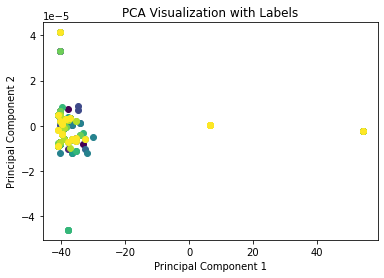

In [ ]:
import matplotlib.cm as cm

unique_labels = np.unique(labels)
num_unique_labels = len(unique_labels)

# Create a colormap with enough colors for your unique labels
colormap = cm.get_cmap('viridis', num_unique_labels)

fig, ax = plt.subplots()
for i, label in enumerate(unique_labels):
    indices = np.where(labels == label)
    ax.scatter(principal_components[indices, 0], principal_components[indices, 1], c=[colormap(i)], label=f'Label {label}')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA Visualization with Labels')
# ax.legend()
plt.show()

